In [1]:
import torch
import torch.nn.functional as F
import torchmetrics

import sys
sys.path.insert(0, '/home/maria/py/dl/my_d2l')
from my_package import preData, fig, hdc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. 加载数据集 MNIST

打印数据集的一些参数

In [2]:
dataset_path = "../../data"
batch_size = 256
train_iter, test_iter = preData.load_data_mnist(path=dataset_path, batch_size=batch_size)

1. len(train_loader)：

train_loader 是一个 DataLoader 对象，它是一个迭代器，用于从数据集中批量加载数据。
len(train_loader) 返回 DataLoader 中的批次数量。由于 DataLoader 通常用于迭代整个数据集，len(train_loader) 给出了数据集中的批次总数。

2. next(iter(train_loader))：

iter(train_loader) 创建了一个迭代器，可以迭代 DataLoader 中的批次。
next(iter(train_loader)) 从迭代器中获取下一个批次。这将返回一个包含特征和标签的元组，类似于 DataLoader 的一次迭代。

3. X_train.shape[1:]：

X_train 是从 DataLoader 中获取的一个批次的特征数据。
X_train.shape 返回 X_train 的维度。例如，如果 X_train 是一个形状为 [batch_size, num_features] 的张量，X_train.shape 将返回 [batch_size, num_features]。
X_train.shape[1:] 通过切片操作获取除了第一个维度（批次大小）之外的所有维度。这通常用于获取每个样本的特征数量。

In [3]:
print("Number of batches in train_loader:", len(train_iter))
print("Number of batches in test_loader:", len(test_iter))

# 获取一个批次的数据
eg_X_train, eg_y_train = next(iter(train_iter))

# 打印特征和标签的形状
print("Shape of each sample (features):", eg_X_train.shape[1:])  # 去掉批次维度
print("Shape of each label:", eg_y_train.shape[1:])  # 标签通常是一维的
print("Data type of sample and label: ", eg_X_train.dtype, eg_y_train.dtype)

# 获取所有唯一的标签
unique_labels = torch.unique(eg_y_train)
# 打印类别的数量
print("Number of classes:", len(unique_labels))

print(eg_X_train.size())

Number of batches in train_loader: 235
Number of batches in test_loader: 40
Shape of each sample (features): torch.Size([1, 28, 28])
Shape of each label: torch.Size([])
Data type of sample and label:  torch.float32 torch.int64
Number of classes: 10
torch.Size([256, 1, 28, 28])


array([<Axes: title={'center': '3'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '8'}>,
       <Axes: title={'center': '5'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '7'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '7'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '8'}>, <Axes: title={'center': '8'}>,
       <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
      dtype=object)

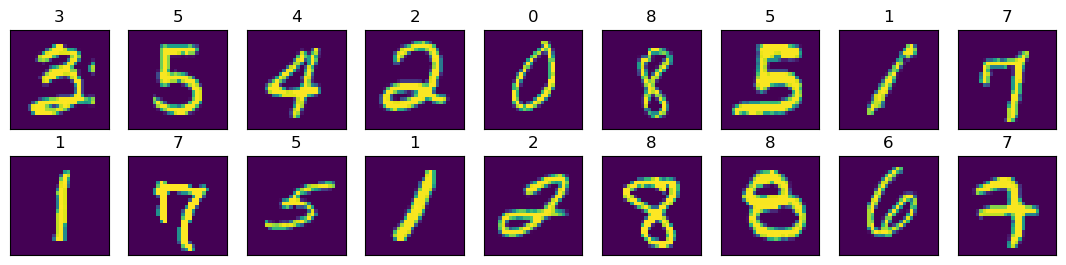

In [4]:
fig.show_mnist_images(eg_X_train.reshape(batch_size, 28, 28), 2, 9, 
                      titles=preData.get_mnist_labels(eg_y_train))

# 2. 定义编码映射和训练

position -> random_vec,
value -> level_vec

对二进制{0, 1}，
bind(pos, value) === pos ^ value

In [5]:
def quant(hv, thre=None, shift=None, datatype='binary'):
    """
    Function
    ===
    Quantinize the element in the HV. 
    Range > thre and <= thre

    Parameter
    ---
    `data type`: the element is within 
    'bipolar' {-1, 1}
    'binary' {0, 1}
    """
    if datatype == 'bipolar':
        return torch.where(hv > thre, torch.ones_like(hv, dtype=torch.uint8),
                           torch.full_like(hv, -1, dtype=torch.uint8))
    elif datatype == 'binary':
        return hv >> shift
    else:
        raise ValueError('Sorry, not supporting datatype.')

r = torch.tensor(
    [[1, 3],
    [4, 0]]
)
torch.stack([quant(vec, shift=1, datatype='binary') for vec in r])

tensor([[0, 1],
        [2, 0]])

In [6]:
def encode(img, pos, val, datatype='binary'):
    """
    Function
    ===
    Encode all the pixels in an image using pos&val IM.

    Parameter
    ----
    Reshape the size (1, 28, 28) to one-dimension
    Quantize the image data(represented in float [0, 1)) to [0, 256).
    img: 一个包含像素值的一维张量
    pos: 一个包含位置向量的二维张量，shape 为 (img_size, vector_size)
    val: 一个包含值向量的二维张量，shape 为 (num_values, vector_size)
    
    Return
    ---

    """
    img = torch.round(img.reshape(-1) * 255).to(torch.int32)

    # 获取 img 中每个像素值对应的索引
    pos_indices = torch.arange(len(img)).unsqueeze(1)  # shape: (len(img), 1)
    pixel_indices = img.unsqueeze(1)  # shape: (len(img), 1)

    # 使用高级索引获取 pos 和 val 中对应的向量
    pos_vectors = pos[pos_indices]  # shape: (len(img), vector_size)
    val_vectors = val[pixel_indices]  # shape: (len(img), vector_size)

    # 对获取的向量进行 bind 操作
    # (-1, 1) *
    # (0, 1) ^
    if datatype == 'bipolar':
        img_hv = pos_vectors * val_vectors  # shape: (len(img), vector_size)
    elif datatype == 'binary':
        img_hv = pos_vectors ^ val_vectors  # shape: (len(img), vector_size)
    else:
        raise ValueError('Sorry, not supporting datatype.')

    img_hv = img_hv.sum(dim=0)
    return img_hv[0]

In [7]:
def train_epoch(AM, X_train, Y_train, pos_IM, val_IM, if_quant=False, datatype='binary'):
    """
    Function
    ===
    For each image in the sample, encode the pixel and position, add to AM.
    Quantinize according to image size.

    After summing up all the samples in one batch, quantinize according to popcount.

    """
    if if_quant:
        accu_AM = torch.zeros_like(AM)
        popcount = torch.zeros(AM.shape[-1])
        for img, label in zip(X_train, Y_train):
            accu_AM[label] += encode(img, pos_IM, val_IM, datatype=datatype)
            popcount[label] += 0
            # print(AM[label], label)
        print(accu_AM, popcount, popcount.sum())
        # AM[:] = torch.stack([quant(vec, thre=27*28 * popcount[i]//2, datatype='binary') for i, vec in enumerate(accu_AM)])
        print(AM)
    else:
        for img, label in zip(X_train, Y_train):
            AM[label] += encode(img, pos_IM, val_IM, datatype=datatype)


In [8]:
def predict(AM, img, pos_IM, val_IM, datatype='binary'):
    """
    Function
    ===
    predict the class of the img according to memory
    First, encode the img to generate the query HV.
    Then compare the query HV with all the entry in AM and find the maximum index.
    """
    query_hv = encode(img, pos_IM, val_IM, datatype=datatype)
    simi = F.cosine_similarity(query_hv.float(), AM.float())

    max_index = torch.argmax(simi).item()
    return max_index

def test(accuracy, AM, X_test, Y_test, pos_IM, val_IM, datatype='binary'):
    """
    Function
    ===
    For each sample in the test dataset, predict the result.
    The overall result is converted to tensor and compared with label.
    """
    Y_pred = []
    for sample in X_test:
        Y_pred.append(predict(AM, sample, pos_IM, val_IM, datatype=datatype))
    Y_pred = torch.tensor(Y_pred).to(device)
    accuracy.update(Y_test, Y_pred)

In [9]:
def train(AM, train_iter, test_iter, pos_IM, val_IM, num_classes, if_quant=False, datatype='binary'):
    test_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes).to(device)

    num_epochs = len(train_iter)
    animator = fig.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['test acc'])
    epoch = 0
    for sample, label in train_iter:
        sample, label = sample.to(device), label.to(device)
        train_epoch(AM=AM, X_train=sample, Y_train=label,
                pos_IM=pos_IM, val_IM=val_IM, if_quant=if_quant, datatype=datatype)

        # test on one batch
        for test_s, test_l in test_iter:
            test_s, test_l = test_s.to(device), test_l.to(device)
            test(accuracy=test_accuracy, AM=AM, X_test=test_s, Y_test=test_l,
                pos_IM=pos_IM, val_IM=val_IM, datatype=datatype)
            break

        animator.add(epoch+1, (test_accuracy.compute().item()))
        fig.plt.show()
        epoch += 1
        if epoch == 30:
            break

# 3. 参数和 HV 初始化

In [13]:
dim = 4096
datatype = 'binary' # 'binary' {0, 1} 'bipolar' {-1, 1}
operation = 'MAP'

img_size = 28 * 28 # size of MNIST image
img_gray_val = 256 # maximum gray scale of MNIST image
num_class = 10 # number of classes inside MNIST dataset

生成 position 即坐标位置的 IM 和每个像素值的 IM
初始化每个类的 AM

In [14]:
if_quant = False
position_IM = hdc.item_memory(dim=dim, number=img_size, datatype=datatype)
grayscale_IM = hdc.item_memory(dim=dim, number=img_gray_val, datatype=datatype)     

AM = torch.zeros(size=(num_class, dim), dtype = torch.int32)
position_IM, grayscale_IM, AM = position_IM.to(device), grayscale_IM.to(device), AM.to(device)

# 4. train and interfere

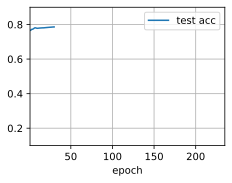

In [15]:
train(AM=AM, train_iter=train_iter, test_iter=test_iter,
      pos_IM=position_IM, val_IM=grayscale_IM, num_classes=num_class,
      if_quant=if_quant, datatype=datatype)

In [16]:
from rich.progress import track
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

for sample, label in track(test_iter, description="Testing"):
    sample, label = sample.to(device), label.to(device)
    test(accuracy, AM, X_test=sample, Y_test=label,
         pos_IM=position_IM, val_IM=grayscale_IM, datatype=datatype)
print(f"Dimension {dim}: Test accuracy is {(accuracy.compute().item() * 100):.3f}%")

Output()

Dimension 4096: Test accuracy is 81.630%


array([<Axes: title={'center': '7'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '2'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '7'}>],
      dtype=object)

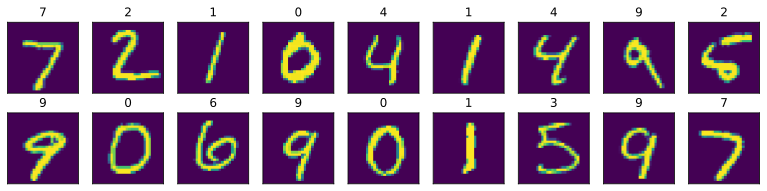

In [18]:
X, y = next(iter(test_iter))
Y_pred = []
for sample in X:
    Y_pred.append(predict(AM, sample, position_IM, grayscale_IM, datatype=datatype))
Y_pred = torch.tensor(Y_pred)
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_mnist_labels(Y_pred))